## 分析PPT.特斯拉相關詞彙關係
### 唯宇 : Class = "性價比"

我們組使用PPT : 關鍵字"特斯拉"的資料，並使用TF-IDF, N-gram等方法找出文章以及字詞間的關聯。 

## 1. 載入套件

In [74]:
# ％pip install -U networkx

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import font_manager

In [76]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [77]:
# cloab 字體設定
import matplotlib
# Path to the custom font
font_path = 'font/TraditionalChinese.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Noto Sans TC


## 2. 資料前處理

### 2.1 基本資料介紹
資料來源：
+ 工作流程平台蒐集 : PPT文章 
+ 時間: 
+ 選擇版別: 
+ 資料筆數：共  則新聞

In [78]:
#匯入資料
df = pd.read_csv('./data/ppt_tesla_classified_cleaned.csv', encoding = 'UTF-8')
df

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面
1,1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"{""文章分類"":""性價比方面"",""情緒"":""負面"",}",負面,性價比方面
2,2,2023-01-02 12:47:31,新聞開特斯拉滑手機被勸嗆網友有毛,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,原文連結原文內容記者王家珩徐兆緯台北報導前電競世界冠軍日前開直播雖然用自動駕駛但雙手卻完全離...,"{ ""文章分類"": ""使用者體驗"", ""情緒"": ""負面"", ""詳細分類"": {""服務...",負面,使用者體驗
3,3,2023-01-02 18:01:04,討論是不是真的有些四輪覺得自己是大爺,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,如題本身開特斯拉最近出門覺得找車位很煩都騎家裡超舊機車基本上在路上有機車道騎機車道沒機車道就...,"{""文章分類"":""使用者體驗"",""情緒"":""負面"",}",負面,使用者體驗
4,4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面
...,...,...,...,...,...,...,...,...
1580,1580,2024-04-30 10:33:35,新聞特斯拉全新入門電動車準備量產,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,哪有到倍那種是油車電動車現在沒有貨物稅以美國現在價格簡單計算台灣萬只比美國售價直接換算貴一點...,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面
1581,1581,2024-04-30 12:24:31,分享撞緩撞車啦,要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...,要系統性的改善緩撞車被撞的問題建議交通部學習美國跟特斯拉的案件作法以後強制要求各車廠開啟後系...,"{""文章分類"": ""政策與法規方面"",""情緒"": ""正面"",""內容"": ""要系統性的改善緩撞...",正面,政策與法規方面
1582,1582,2024-04-30 17:45:19,新聞銷售降溫賓士上季獲利銳減逾三成福斯,都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...,都轉單到特斯拉了誰跟你買雙不針對本板及有多位朋友同想法都了還在特斯拉搶走雙客群就我看賓士的衰...,"{""文章分類"": ""使用者體驗"",""情緒"": ""正面""}",正面,使用者體驗
1583,1583,2024-04-30 19:19:58,問題,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,最近物色下一台車原本抓左右上週去看了特斯拉這周去看了爆預算爆很大目前用車都是十年以上換車里程...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面


In [79]:
#查看各class筆數分佈
df.groupby('class').size()

# 查看各個類別的筆數
class_counts = df['class'].value_counts()

print(class_counts)

性價比方面                       569
安全性方面                       460
使用者體驗                       448
服務方面                         18
車輛交付方面                       11
新聞報導                          6
政策方面                          2
性價比方面、使用者體驗                   2
歷史與政策方面                       1
意見與分析                         1
政治及經濟方面                       1
總體觀念                          1
車輛銷量方面                        1
車輛預售方面                        1
保險方面                          1
意見與評估                         1
性價比方面與安全性方面                   1
政治方面                          1
事故報導                          1
法律方面                          1
人工智慧交通運輸汽車科技                  1
性價比方面、使用者體驗、安全性方面、車輛交付方面      1
進口車座談會                        1
性價比方面、使用者體驗、安全性方面             1
車馬費方面                         1
歷史與文化方面                       1
資訊傳遞方面                        1
故事                            1
來源                            1
新聞                            1
進口車銷售方面                       1
政策與法規方面 

### 2.2 資料清理  
- 去除特殊字元與標點符號，只留下中文字
- \u4e00-\u9fff 為Unicode中文漢字字符的範圍

In [80]:
MetaData = df.copy()
# 保留 'class' 列中值為 '性價比方面' 的行，改這裡
MetaData = MetaData[MetaData['class'] == '性價比方面']
# 去除一些不需要的欄位
#MetaData = MetaData.drop(['dataSource'], axis=1)
MetaData['artContent'] = MetaData['artContent'].astype(str)
# 只留下中文字
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

MetaData.head(5)

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面
1,1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"{""文章分類"":""性價比方面"",""情緒"":""負面"",}",負面,性價比方面
4,4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面
5,5,2023-01-02 22:03:33,新聞美國汽車召回排名揭曉第一名超過,nan,,"{""文章分類"":""性價比方面"",""情緒"":""負面"",}",負面,性價比方面
7,7,2023-01-03 12:31:28,新聞又是破紀錄的一年特斯拉年交車,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...,"{""文章分類"": ""性價比方面"",""情緒"": ""正面""}",正面,性價比方面


### 2.3 文章斷詞與整理

In [81]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [82]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [83]:
data = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
data['word'] = data.sentence.apply(getToken).explode('word')

data.head(3)

Building prefix dict from d:\114 NSYSU MIS\SMA_project 4\SMA_project\王唯宇\dict\dict.txt.big ...
Loading model from cache C:\Users\hands\AppData\Local\Temp\jieba.u11367bc61a3dd4fc2404c9c1ab067500.cache
Loading model cost 1.613 seconds.
Prefix dict has been built successfully.


,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class,word
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,八卦
1,1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"{""文章分類"":""性價比方面"",""情緒"":""負面"",}",負面,性價比方面,官網
4,4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面,第三方


## 3. 找出重要詞彙 - 以TFIDF為例

TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度  
- **TF** (Term Frequency)：某一個詞彙在某一個文件中所出現的頻率  
    - TF = 詞彙在該文件中出現次數 / 該文件中詞彙總數  
- **IDF** (Inverse Document Frequent)：為文件數除以某特定詞彙有被多少文件所提及的數量取log  
    - IDF = log( 總文件數量 / 包含該詞彙的文件數量 ) 

### 3.1 應用於資料集（套件）

In [84]:
udn_df = MetaData.copy()
udn_df.head(3)

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面
1,1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"{""文章分類"":""性價比方面"",""情緒"":""負面"",}",負面,性價比方面
4,4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面


In [85]:
# 保留需要的欄位、sentiment、class
udn_df = udn_df.loc[:,["system_id", "sentence","sentiment","class"]]

# 改成使用空格連接斷完的詞
udn_df['word'] = udn_df.sentence.apply(getToken).map(' '.join)

udn_df.head()

,system_id,sentence,sentiment,class,word
0,0,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,正面,性價比方面,八卦 官網 特斯拉 二手車 第三方 平台 便宜 黨會 勝利
1,1,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,負面,性價比方面,前輩 中古 特斯拉 里程 擔心 電池 掉電 越充 越少電 里程 數越 少開 車子 變成 垃圾...
4,4,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,負面,性價比方面,美國 汽車 召回 排名 揭曉 第一名 超過 進廠 處理 結束 迎來 許多年 數據 揭曉 美國...
5,5,,負面,性價比方面,
7,7,原文連結原文內容又是破紀錄的一年特斯拉年交車成績單揭曉全年總量突破萬輛大關特斯拉正式對外公布...,正面,性價比方面,破紀錄 一年 特斯拉 年交車 成績單 揭曉 總量 突破 大關 特斯拉 正式 對外 公布 生產...


In [86]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(udn_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一丁點,一下,一事,一五,一人出,一代,一件,一份,一位,一併,...,齊全,齒輪,齒輪油,齡年,龍吟,龍頭,龍頭企業,龐大,龜山,龜毛
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
566,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
transformer = TfidfTransformer()  
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

#TFIDF_df

### 3.2 檢視結果   
根據tfidf值來挑出重要詞彙的方法有許多種，以下舉兩個方法當範例：
- 取每一個字詞在所有文件裡的TF-IDF平均值
- 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

#### 方法1： 取每一個字詞在所有文件裡的TF-IDF平均值

In [88]:
udn_tfidf = TFIDF_df.mean().to_frame().reset_index()
udn_tfidf.columns = ["word", "avg"]

udn_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
7361,特斯拉,0.046858
11455,電動車,0.045595
2605,台灣,0.030877
585,中國,0.029714
11483,電池,0.027653
1527,充電,0.026956
11514,電車,0.025400
6750,汽車,0.023141
2801,品牌,0.020839
11255,降價,0.020234


#### 方法2： 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [89]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一丁點,一下,一事,一五,一人出,一代,一件,一份,一位,...,齊全,齒輪,齒輪油,齡年,龍吟,龍頭,龍頭企業,龐大,龜山,龜毛
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
565,566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
566,567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
567,568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一丁點,0.0
1,2,一丁點,0.0
2,3,一丁點,0.0
3,4,一丁點,0.0
4,5,一丁點,0.0
...,...,...,...
6826288,565,龜毛,0.0
6826289,566,龜毛,0.0
6826290,567,龜毛,0.0
6826291,568,龜毛,0.0


nlargest() 會回傳指定列中最大的前x個值所對應的資料

In [91]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)
   
    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

,word,size
3221,電動車,70
3228,電池,39
194,中國,34
2000,汽車,33
2159,特斯拉,32
506,充電,31
3235,電車,30
2615,萬元,27
849,台灣,27
910,品牌,27


## 4. 透過結巴斷詞與N-gram幫助建立斷詞字典
N-gram 指文本中連續出現的n個語詞。   
透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。   

### 4.1 Bigram

In [92]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]
    
    return seg_list

In [93]:
udn_bigram = MetaData.copy()

udn_bigram["word"] = udn_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
udn_bigram = udn_bigram.explode('word')

udn_bigram.head(3)

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class,word
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,八卦 官網
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,官網 特斯拉
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,特斯拉 二手車


#### 統計最常出現的bigram組合

In [94]:
# 計算每個組合出現的次數
udn_bigram_count = udn_bigram['word'].value_counts().reset_index()

# 重命名列
udn_bigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
udn_bigram_count_sorted = udn_bigram_count.sort_values('count', ascending=False).head(20)

print(udn_bigram_count_sorted)

       word  count
0    汽車 製造商     62
1     台幣 萬元     57
2     萬元 台幣     45
3     中國 品牌     45
4    特斯拉 車主     43
5     汽車 中國     42
6    中國 電動車     40
7   意見 標點符號     39
8    電動車 電池     39
9     傳統 汽車     38
10   電動車 銷量     36
11   電動車 銷售     32
12    新創 公司     31
13    寧德 時代     30
14    續航 里程     29
15   特斯拉 降價     28
16   台灣 特斯拉     28
17    保養 費用     26
18    豪華 品牌     26
19   消費者 報告     25


### 4.2 Trigram

In [95]:
udn_trigram = MetaData.copy()

udn_trigram["word"] = udn_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
udn_trigram = udn_trigram.explode('word')

udn_trigram.head(3)

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class,word
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,八卦 官網 特斯拉
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,官網 特斯拉 二手車
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,特斯拉 二手車 第三方


#### 統計最常出現的trigram組合

In [96]:
# 計算每個組合出現的次數
udn_trigram_count = udn_trigram['word'].value_counts().reset_index()

# 重命名列
udn_trigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
udn_trigram_count_sorted = udn_trigram_count.sort_values('count', ascending=False).head(20)

print(udn_trigram_count_sorted)

          word  count
0     萬元 台幣 萬元     20
2     美元 萬元 台幣     17
1    人民幣 萬元 台幣     17
3     北美 充電 標準     14
4     銷量 累計 銷量     13
5    傳統 汽車 製造商     13
6     累計 銷量 累計     13
7     召回 次數 召回     12
8     傳統 汽車 廠商     10
9     美元 台幣 萬元     10
10    金元 台幣 萬元     10
11    次數 召回 總數     10
14  百分比 適用 百分比      9
15   適用 百分比 適用      9
13    總數 召回 次數      9
12    召回 總數 召回      9
16    公里 續航 里程      7
17   售價 人民幣 萬元      7
18    售價 金元 台幣      7
26    拒絕 購買 中國      6


從上面的 bigram 和 trigram 的結果中，我們把常一起出現的詞彙加入自訂義辭典 "lexicon" 中，例如:柯文哲。

### 4.3 使用自建字典

In [97]:
# 新增自定義字典
jieba.load_userdict('./dict/lexicon.txt')

**使用自建辭典進行斷詞與計算**

In [98]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class,word
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,八卦
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,官網
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,特斯拉


### 4.4 Bigram視覺化

更新斷詞字典後重新進行bigram斷詞

In [99]:
bigramudist = MetaData.copy()

bigramudist["word"] = bigramudist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramudist = bigramudist.explode('word')

bigramudist.head(3)

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class,word
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,八卦 官網
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,官網 特斯拉
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,特斯拉 二手車


In [100]:
#去除bigramudist["word"]內容為空值的筆數
bigramudist.dropna(subset = ['word'], axis=0, how='any', inplace=True)

In [101]:
# 計算每個組合出現的次數
udn_bigram_count = udn_bigram['word'].value_counts().reset_index()

# 重命名列
udn_bigram_count.columns = ['word', 'count']

# 按照 count 排序並顯示前 20 個結果
udn_bigram_count_sorted = udn_bigram_count.sort_values('count', ascending=False).head(20)

print(udn_bigram_count_sorted)

       word  count
0    汽車 製造商     62
1     台幣 萬元     57
2     萬元 台幣     45
3     中國 品牌     45
4    特斯拉 車主     43
5     汽車 中國     42
6    中國 電動車     40
7   意見 標點符號     39
8    電動車 電池     39
9     傳統 汽車     38
10   電動車 銷量     36
11   電動車 銷售     32
12    新創 公司     31
13    寧德 時代     30
14    續航 里程     29
15   特斯拉 降價     28
16   台灣 特斯拉     28
17    保養 費用     26
18    豪華 品牌     26
19   消費者 報告     25


In [102]:
bigramudist['word'] = bigramudist['word'].astype(str)
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramudist = FreqDist(bigramudist['word'].apply(lambda x: tuple(x.split(' '))))
bigramudist.most_common(5)

[(('汽車', '製造商'), 62),
 (('台幣', '萬元'), 57),
 (('萬元', '台幣'), 45),
 (('中國', '品牌'), 45),
 (('特斯拉', '車主'), 43)]

In [103]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramudist.most_common(50)}
d.items()

dict_items([(('汽車', '製造商'), 62), (('台幣', '萬元'), 57), (('萬元', '台幣'), 45), (('中國', '品牌'), 45), (('特斯拉', '車主'), 43), (('汽車', '中國'), 42), (('中國', '電動車'), 40), (('意見', '標點符號'), 39), (('電動車', '電池'), 39), (('傳統', '汽車'), 38), (('電動車', '銷量'), 36), (('電動車', '銷售'), 32), (('新創', '公司'), 31), (('寧德', '時代'), 30), (('續航', '里程'), 29), (('台灣', '特斯拉'), 28), (('特斯拉', '降價'), 28), (('豪華', '品牌'), 26), (('保養', '費用'), 26), (('傳統', '車廠'), 25), (('電動車', '品牌'), 25), (('中國', '汽車'), 25), (('消費者', '報告'), 25), (('美國', '電動車'), 24), (('汽車', '廠商'), 24), (('福斯', '汽車'), 23), (('全球', '電動車'), 23), (('充電', '規格'), 23), (('充電', '標準'), 23), (('累計', '銷量'), 21), (('人民幣', '萬元'), 20), (('特斯拉', '充電'), 20), (('召回', '次數'), 19), (('電池', '製造商'), 19), (('特斯拉', '電動車'), 18), (('工廠', '生產'), 18), (('油電', '混合'), 18), (('電池', '工廠'), 18), (('全球', '汽車'), 18), (('充電', '網路'), 18), (('北美', '充電'), 18), (('特斯拉', '台灣'), 17), (('現代', '汽車'), 17), (('美元', '萬元'), 17), (('取消', '訂單'), 16), (('數據', '顯示'), 15), (('生產', '電動車'), 15), (('銷售', '電動車'), 15), (('電動車

In [104]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    print(k[0])
    print(v)
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率
    
# 取得edge權重
weights = [w[2]['weight']*0.001 for w in  G.edges(data=True)]

汽車
62
台幣
57
萬元
45
中國
45
特斯拉
43
汽車
42
中國
40
意見
39
電動車
39
傳統
38
電動車
36
電動車
32
新創
31
寧德
30
續航
29
台灣
28
特斯拉
28
豪華
26
保養
26
傳統
25
電動車
25
中國
25
消費者
25
美國
24
汽車
24
福斯
23
全球
23
充電
23
充電
23
累計
21
人民幣
20
特斯拉
20
召回
19
電池
19
特斯拉
18
工廠
18
油電
18
電池
18
全球
18
充電
18
北美
18
特斯拉
17
現代
17
美元
17
取消
16
數據
15
生產
15
銷售
15
電動車
15
電動車
15


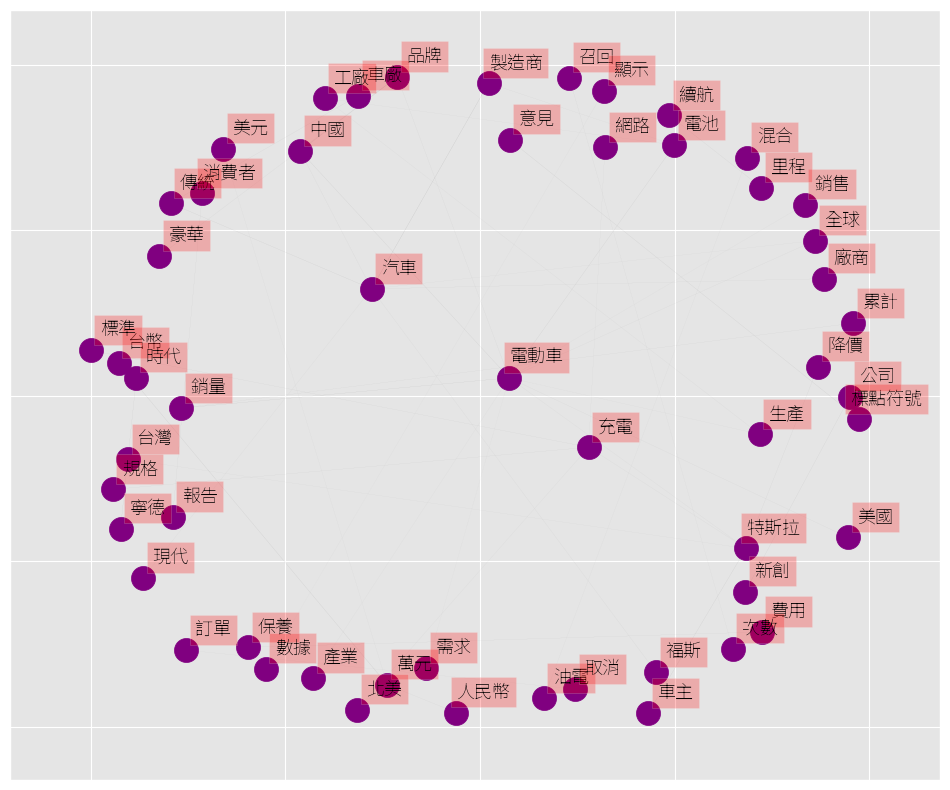

In [105]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=4)# k越大，斥力越小l;k越小，斥力越大

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
plt.show()

**發現** 
+   .... 
+   .... 
+   .... 



## 5. Pairwise correlation
計算兩個詞彙間的相關性 Pearson correlation

In [106]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class,word
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,八卦 官網 特斯拉 二手車 第三方 平台 便宜 黨會 勝利
1,1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"{""文章分類"":""性價比方面"",""情緒"":""負面"",}",負面,性價比方面,前輩 中古 特斯拉 里程 擔心 電池 掉電 越充 越少電 里程 數越 少開 車子 變成 垃圾...
4,4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面,美國 汽車 召回 排名 揭曉 第一名 超過 進廠 處理 結束 迎來 許多年 數據 揭曉 美國...


In [107]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一下,一台,一堆,一年,一次,一直,一點,上市,下滑,下降,...,面臨,韓國,預期,預算,預計,顯示,馬力,馬達,駕駛,高達
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,2,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
566,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
567,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [108]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,一下,一台,一堆,一年,一次,一直,一點,上市,下滑,...,面臨,韓國,預期,預算,預計,顯示,馬力,馬達,駕駛,高達
0,一下,1.000000,0.254600,-0.026268,-0.050850,0.160115,0.173111,0.188385,-0.016879,-0.036564,...,-0.039435,-0.026654,0.134752,0.001706,-0.003470,0.077203,-0.030396,-0.011798,0.139466,-0.004248
1,一台,0.254600,1.000000,-0.016565,0.056600,0.061284,0.190068,0.187495,-0.027246,-0.006908,...,-0.019131,-0.039146,-0.033679,0.089810,-0.019876,0.239296,0.045172,0.019506,0.177596,-0.036491
2,一堆,-0.026268,-0.016565,1.000000,-0.046029,-0.039231,-0.000974,0.112109,-0.011856,-0.027837,...,-0.048641,-0.037691,-0.051701,0.066124,-0.063512,-0.040104,0.072979,0.024415,-0.044729,-0.035394
3,一年,-0.050850,0.056600,-0.046029,1.000000,-0.000110,-0.018322,0.008066,-0.014284,0.059229,...,0.143428,-0.029123,0.001280,-0.002691,0.045849,0.057127,0.088984,-0.039536,-0.002749,-0.037752
4,一次,0.160115,0.061284,-0.039231,-0.000110,1.000000,0.094480,0.145110,-0.041215,0.009757,...,-0.026571,-0.032410,-0.001216,0.118098,-0.054615,-0.013415,-0.009906,0.050163,0.037243,0.066732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,顯示,0.077203,0.239296,-0.040104,0.057127,-0.013415,0.096115,0.089580,0.023366,0.113827,...,0.229756,0.174242,0.031143,-0.013624,0.114625,1.000000,-0.018074,0.004375,0.373772,0.122356
296,馬力,-0.030396,0.045172,0.072979,0.088984,-0.009906,0.061681,0.000558,-0.006088,-0.029124,...,-0.011340,-0.010653,-0.035093,0.041661,-0.015341,-0.018074,1.000000,0.201604,0.082084,-0.023035
297,馬達,-0.011798,0.019506,0.024415,-0.039536,0.050163,0.014098,0.096457,0.031653,-0.032141,...,-0.025361,-0.016791,-0.038728,0.064350,0.009176,0.004375,0.201604,1.000000,0.030425,0.041748
298,駕駛,0.139466,0.177596,-0.044729,-0.002749,0.037243,0.102927,0.054726,0.105095,-0.032772,...,-0.030699,0.317888,-0.021199,0.141162,0.050690,0.373772,0.082084,0.030425,1.000000,0.066433


In [109]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
25340,時代,寧德,0.927618
42084,寧德,時代,0.927618
17026,訂單,取消,0.926615
67856,取消,訂單,0.926615
46607,意見,標點符號,0.925665
32255,標點符號,意見,0.925665
71727,保養,費用,0.836535
8339,費用,保養,0.836535
58568,喜歡,空間,0.816368
20595,空間,喜歡,0.816368


In [110]:
word_cor_df

,word1,word2,cor
1,一台,一下,0.254600
2,一堆,一下,-0.026268
3,一年,一下,-0.050850
4,一次,一下,0.160115
5,一直,一下,0.173111
...,...,...,...
89994,預計,高達,0.236680
89995,顯示,高達,0.122356
89996,馬力,高達,-0.023035
89997,馬達,高達,0.041748


### 5.1 和 「特斯拉」, 「電動車」 相關性最高的 10 個詞彙

In [111]:
stopword_list = ['差格','還可','抱不平','看影組',"標點符號","男女皆可"]  # 停用词列表

p = word_cor_df[~word_cor_df["word2"].isin(stopword_list) & (word_cor_df["word1"] == "特斯拉")].sort_values(by='cor', ascending=False).head(10)
k = word_cor_df[~word_cor_df["word2"].isin(stopword_list) & (word_cor_df["word1"] == "電動車")].sort_values(by='cor', ascending=False).head(10)

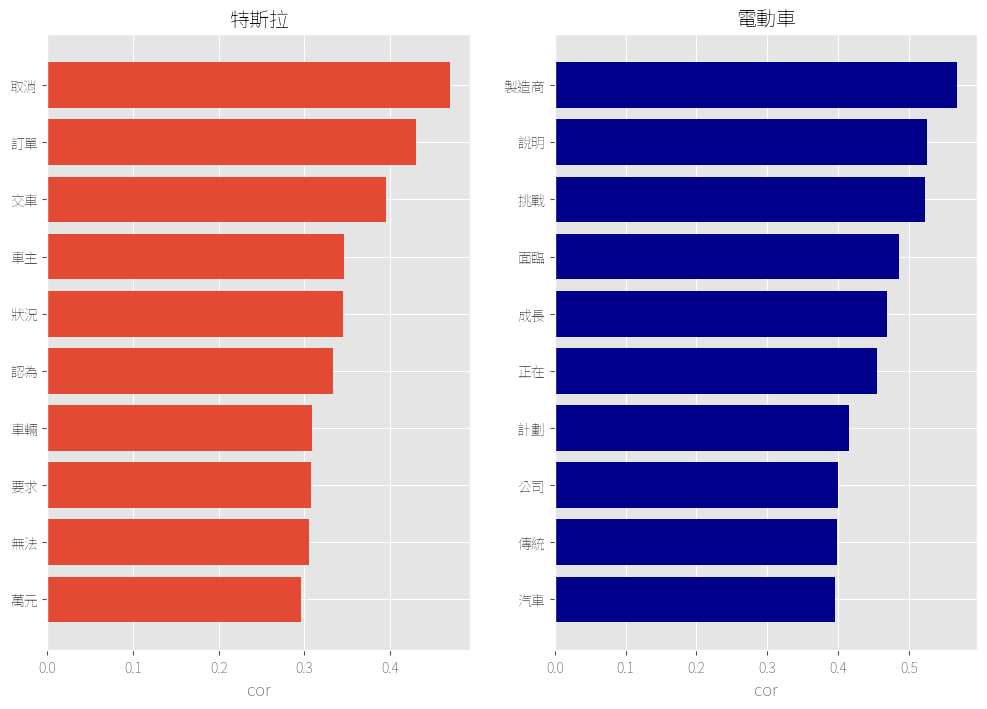

In [112]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('特斯拉')
plt.xlabel('cor')
plt.barh(p['word2'],p['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('電動車')
plt.xlabel('cor')
plt.barh(k['word2'],k['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

本資料 : "insight" 

### 5.2 使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.5的組合

In [113]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [114]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.35的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.5]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,德國,中國,0.542506
1,充電,使用,0.503376
2,使用,充電,0.503376
3,售價,台幣,0.624898
4,萬元,台幣,0.744636
5,台幣,售價,0.624898
6,萬元,售價,0.608663
7,車型,售價,0.525556
8,生產,工廠,0.549287
9,中國,德國,0.542506


In [115]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*3 for w in  g.edges(data=True)]

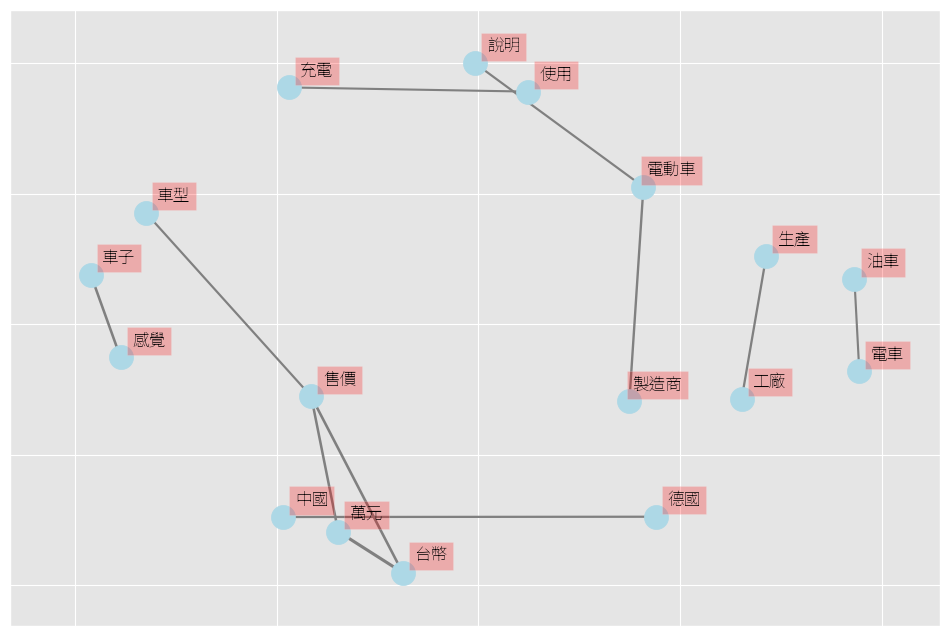

In [116]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=1)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()

詞頻前60為節點且相關性高於0.5的組合中，可以發現候選人都會與其政黨相關，除了國民黨與侯友宜沒有連到線，原因是兩者關聯0.45，小於0.5，相對於其他兩組候選人沒這麼強烈。

In [117]:
word_cor_df[(word_cor_df['word1']=='電池')&(word_cor_df['word2']=='特斯拉')]

,word1,word2,cor
50687,電池,特斯拉,0.158284


In [118]:
word_cor_df[(word_cor_df['word1']=='哨兵')&(word_cor_df['word2']=='輔助駕駛')]

,word1,word2,cor


In [119]:
word_cor_df[(word_cor_df['word1']=='電動車')&(word_cor_df['word2']=='空間')]

,word1,word2,cor
58786,電動車,空間,-0.042192


## 6. 計算文章相似度
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章   

<img src="./img/pic3.PNG" style="float:left;" width="50%">  

In [120]:
data_cos = data_cor.copy()
data_cos.head(3)

,system_id,artDate,artTitle,artContent,sentence,LLM,sentiment,class,word
0,0,2023-01-01 10:48:19,情報慟特斯拉二手價跌好多,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,八卦是官網特斯拉二手車比很多第三方平台都便宜等等黨會勝利嗎,"{""文章分類"": ""性價比方面"",""情緒"": ""正面"",}",正面,性價比方面,八卦 官網 特斯拉 二手車 第三方 平台 便宜 黨會 勝利
1,1,2023-01-01 22:42:25,問題特斯拉久了會掉電嗎,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,各位前輩好想買中古特斯拉里程約萬上下的擔心電池久了會掉電越充越少電里程數越少開了年後車子變成...,"{""文章分類"":""性價比方面"",""情緒"":""負面"",}",負面,性價比方面,前輩 中古 特斯拉 里程 擔心 電池 掉電 越充 越少電 里程 數越 少開 車子 變成 垃圾...
4,4,2023-01-02 19:21:24,新聞美國汽車召回排名揭曉第一名超過,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,原文連結原文內容美國汽車召回排名揭曉第一名超過萬輛車進廠處理結束迎來許多年的數據也立刻揭曉來...,"{""文章分類"": ""性價比方面"",""情緒"": ""負面"",}",負面,性價比方面,美國 汽車 召回 排名 揭曉 第一名 超過 進廠 處理 結束 迎來 許多年 數據 揭曉 美國...


In [121]:
transformer = TfidfTransformer()  
print(transformer) 
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)  

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,一下,一台,一堆,一年,一次,一直,一點,上市,下滑,下降,...,面臨,韓國,預期,預算,預計,顯示,馬力,馬達,駕駛,高達
0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.221180,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.125434,0.0,0.0,0.139562,0.0
3,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.0,0.000000,0.0,0.050427,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.060123,0.058968,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
565,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
566,0.0,0.000000,0.0,0.000000,0.0,0.0,0.159912,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
567,0.0,0.134517,0.0,0.158659,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.177548,0.0,0.000000,0.0,0.0,0.000000,0.0


計算文章間的cosine similarity

In [122]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

檢視

In [123]:
cos_df = pd.DataFrame(cosine_matrix[2], columns = ['cos_similarity'])
cos_df

,cos_similarity
0,0.009530
1,0.004019
2,1.000000
3,0.000000
4,0.050690
...,...
564,0.029049
565,0.034136
566,0.051588
567,0.002976


In [124]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity", "artTitle", "artContent"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artContent
2,1.000000,NaN,NaN
377,0.883713,新聞獨油電車被放三角錐車主要告引網路,原文連結原文內容獨油電車被放三角錐車主要告引網路論戰民眾買了一部他牌油電車停在百貨公司特斯拉...
210,0.799287,NaN,NaN
363,0.678112,NaN,NaN
37,0.264064,討論再來不能用中國製當藉口的吧,中國的一降再降特粉總是說中國製成本低中國車不能整車進口再怎麼便宜跟台灣無關但今天美國跳水這樣...
65,0.253443,NaN,NaN
314,0.184301,NaN,NaN
97,0.174839,NaN,NaN
116,0.167954,NaN,NaN
223,0.158258,討論中國雪鐵龍降價求生存,這個我這邊的感知來看可以認證目前我西台灣車市腥風血雨群眾歡呼雀躍大喊透露一些目前的車價括號內...


發現與文章"義務役新兵看過來 入伍結訓震撼教育攻略圖表在這裡"相關的文章都會與國防部與兵役有關

## 7. 建立Ngram預測模型

In [125]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [126]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

### 以Bigram預測下一個出現的詞

因為本資料集的是"特斯拉"，故以"電動車"相關詞彙作為預測。

In [127]:
bi_prediction = ngram(sen_tokens, N=2)

In [128]:
text = '哨兵'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 模式, probability: 1


發現大選預測下一個詞友年輕人、倒數、今日、開票、投票。其中年輕人推測是呼籲年輕人返鄉投票

In [129]:
text = '特斯拉'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 車主, probability: 0.0373
next word: 降價, probability: 0.0243
next word: 充電, probability: 0.0173
next word: 電動車, probability: 0.0156
next word: 台灣, probability: 0.0147


由上面的預測的確可以發現，年輕人相關詞友包括返鄉、支持等呼籲性字詞

接著，我們探討總統候選人的預測字詞

In [130]:
text = '電動車'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 電池, probability: 0.0371
next word: 銷量, probability: 0.0343
next word: 銷售, probability: 0.0305
next word: 品牌, probability: 0.0238
next word: 產業, probability: 0.0143


In [131]:
text = '車格'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 動力, probability: 0.25
next word: 剛剛, probability: 0.25
next word: 電池, probability: 0.25
next word: 車型, probability: 0.25


In [132]:
text = '電池'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 製造商, probability: 0.036
next word: 工廠, probability: 0.0341
next word: 更換, probability: 0.0284
next word: 成本, probability: 0.0265
next word: 技術, probability: 0.0265


發現 insight : 